In [1]:
# STEP 1: MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# STEP 2: INSTALL DEPENDENCIES
!pip install scikit-learn moviepy

In [3]:
# STEP 3: IMPORT LIBRARIES
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from moviepy.editor import ImageSequenceClip
from collections import Counter
import io
from PIL import Image, ImageSequence
import pandas as pd
from tqdm import tqdm
import os
import imageio.v2 as imageio
import shutil

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



In [4]:
# Upload your video to Colab or mount Drive if needed
video_path = f"Arnab.mp4" # <-- change this to your video path

# VIBGYOR + White + Black color ranges in HSV
color_ranges = {
    'Violet':   ((125, 50, 50),  (145, 255, 255)),
    'Indigo':   ((111, 50, 50),  (124, 255, 255)),
    'Blue':     ((90, 50, 50),   (110, 255, 255)),
    'Green':    ((40, 50, 50),   (89, 255, 255)),
    'Yellow':   ((25, 50, 50),   (34, 255, 255)),
    'Orange':   ((10, 50, 50),   (24, 255, 255)),
    'Red1':     ((0, 50, 50),    (9, 255, 255)),
    'Red2':     ((170, 50, 50),  (180, 255, 255)),
    'White':    ((0, 0, 200),    (180, 30, 255)),
    'Black':    ((0, 0, 0),      (180, 255, 50)),
}

def group_colors(hsv_frame):
    color_counts = {color: 0 for color in ['Violet', 'Indigo', 'Blue', 'Green', 'Yellow', 'Orange', 'Red', 'White', 'Black']}

    for color, (lower, upper) in color_ranges.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8)
        mask = cv2.inRange(hsv_frame, lower, upper)
        count = np.count_nonzero(mask)

        if color.startswith("Red"):
            color_counts["Red"] += count
        else:
            color_counts[color] += count

    total_pixels = hsv_frame.shape[0] * hsv_frame.shape[1]
    percent_dict = {k: round((v / total_pixels) * 100, 2) for k, v in color_counts.items()}

    return color_counts, percent_dict

# Load the video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

results = []

print("Analyzing video frames...")

for i in tqdm(range(frame_count)):
    ret, frame = cap.read()
    if not ret:
        break

    timestamp_ms = int((i / fps) * 1000)
    timestamp = f"{timestamp_ms} ms"

    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    color_counts, color_percents = group_colors(hsv)

    results.append({
        'timestamp': timestamp,
        'pixel_counts': color_counts,
        'pixel_percentages': color_percents
    })

cap.release()

# Convert to DataFrame
df = pd.DataFrame(results)
df.head()

Analyzing video frames...


100%|██████████| 1578/1578 [01:15<00:00, 20.89it/s]


,timestamp,pixel_counts,pixel_percentages
0,0 ms,"{'Violet': 0, 'Indigo': 4, 'Blue': 49709, 'Gre...","{'Violet': 0.0, 'Indigo': 0.0, 'Blue': 2.4, 'G..."
1,41 ms,"{'Violet': 0, 'Indigo': 2, 'Blue': 49763, 'Gre...","{'Violet': 0.0, 'Indigo': 0.0, 'Blue': 2.4, 'G..."
2,83 ms,"{'Violet': 0, 'Indigo': 3, 'Blue': 49590, 'Gre...","{'Violet': 0.0, 'Indigo': 0.0, 'Blue': 2.39, '..."
3,125 ms,"{'Violet': 0, 'Indigo': 3, 'Blue': 49561, 'Gre...","{'Violet': 0.0, 'Indigo': 0.0, 'Blue': 2.39, '..."
4,166 ms,"{'Violet': 0, 'Indigo': 4, 'Blue': 49557, 'Gre...","{'Violet': 0.0, 'Indigo': 0.0, 'Blue': 2.39, '..."


In [8]:
# Color map for VIBGYOR + White + Black
color_map = {
    'Violet': '#8F00FF',
    'Indigo': '#4B0082',
    'Blue':   '#0000FF',
    'Green':  '#00FF00',
    'Yellow': '#FFFF00',
    'Orange': '#FFA500',
    'Red':    '#FF0000',
    'White':  '#EEEEEE',  # Off-white for visibility
    'Black':  '#000000',
}

# Downsample
df_anim = df.iloc[::30].reset_index(drop=True)
total_frames = len(df_anim)
chunk_size = 1000

# Create temp folders
os.makedirs("frames", exist_ok=True)
os.makedirs("gif_chunks", exist_ok=True)

# Generate frames and intermediate GIFs in chunks
num_chunks = (total_frames + chunk_size - 1) // chunk_size

for chunk_idx in tqdm(range(num_chunks), desc="Processing chunks"):
    start = chunk_idx * chunk_size
    end = min(start + chunk_size, total_frames)
    current_chunk = df_anim.iloc[start:end]

    # Generate frames for current chunk
    for i, row in enumerate(current_chunk.itertuples(), start=0):
        colors = [color_map[color] for color in row.pixel_percentages.keys()]
        plt.figure(figsize=(8, 5))
        plt.bar(row.pixel_percentages.keys(), row.pixel_percentages.values(), color=colors)
        plt.ylim(0, 100)
        plt.title(f"Time: {row.timestamp}")
        plt.ylabel("Pixel %")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"frames/frame_{i:04d}.png")
        plt.close()

    # Create GIF for current chunk
    images = [imageio.imread(f"frames/frame_{i:04d}.png") for i in range(len(current_chunk))]
    gif_chunk_path = f"gif_chunks/chunk_{chunk_idx:03d}.gif"
    imageio.mimsave(gif_chunk_path, images, fps=10)

    # Delete the frames to free up space
    shutil.rmtree("frames")
    os.makedirs("frames", exist_ok=True)

# Final step: Combine all GIF chunks into one
# imageio doesn't support GIF appending natively, so we stitch using frames

final_gif_frames = []
chunk_files = sorted(os.listdir("gif_chunks"))



Processing chunks: 100%|██████████| 1/1 [00:11<00:00, 11.27s/it]


In [9]:
# Path to your directory containing GIFs
gif_dir = "/content/gif_chunks/"  # e.g., 'gifs/' or './my_gifs'

# Automatically collect all .gif files in the directory
gif_files = [os.path.join(gif_dir, f) for f in os.listdir(gif_dir) if f.endswith('.gif')]

# Optional: sort files alphabetically optional)
gif_files.sort()

# Set a target size (you can also use the size of the first frame instead)
target_size = (320, 240)

# Load and resize all frames
all_frames = []
for gif_file in gif_files:
    print(f"Processing: {gif_file}")
    with Image.open(gif_file) as im:
        for frame in ImageSequence.Iterator(im):
            #frame = frame.convert('RGBA').resize(target_size)
            frame = frame.convert('RGBA')
            all_frames.append(frame)

# Save the combined GIF
output_path = 'merged.gif'
all_frames[0].save(
    output_path,
    save_all=True,
    append_images=all_frames[1:],
    duration=100,
    loop=0
)

print(f"Merged GIF saved at: {output_path}")


Processing: /content/gif_chunks/chunk_000.gif
Merged GIF saved at: merged.gif


Overall Colour Distribution (%):
Red       27.421439
Indigo    15.042808
White     11.927490
Black      9.796974
Orange     7.359673
Violet     6.742946
Blue       5.222620
Yellow     3.289947
Green      0.861872
dtype: float64


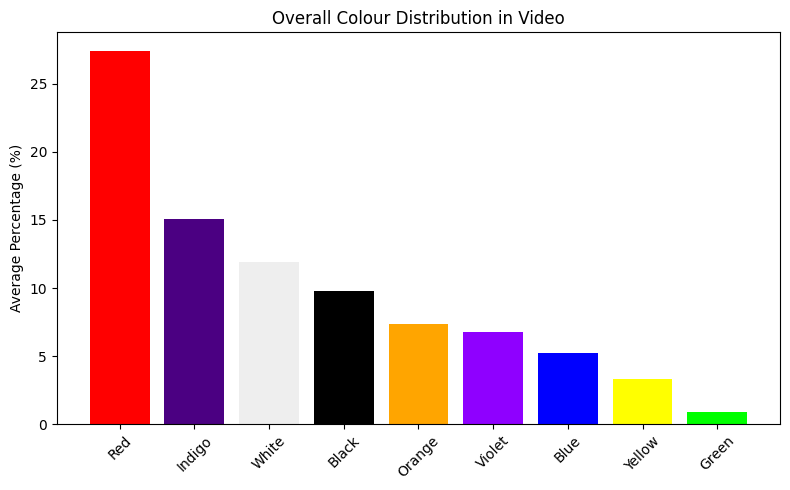

In [34]:
# Extract pixel percentage dictionaries into a list of DataFrames
percent_dfs = pd.DataFrame(df['pixel_percentages'].tolist())

# Compute average percentage of each colour across all frames
overall_distribution = percent_dfs.mean().sort_values(ascending=False)

print("Overall Colour Distribution (%):")
print(overall_distribution)

# Plot overall distribution
plt.figure(figsize=(8, 5))
colors = [color_map[c] for c in overall_distribution.index]  # match your defined color_map
plt.bar(overall_distribution.index, overall_distribution.values, color=colors)
plt.ylabel("Average Percentage (%)")
plt.title("Overall Colour Distribution in Video")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Share of video time where each colour is dominant (%):
Red       80.446515
Black      7.621114
Orange     5.065780
Indigo     3.542840
White      1.995319
Blue       0.671162
Yellow     0.415736
Violet     0.226571
Green      0.014962
Name: proportion, dtype: float64


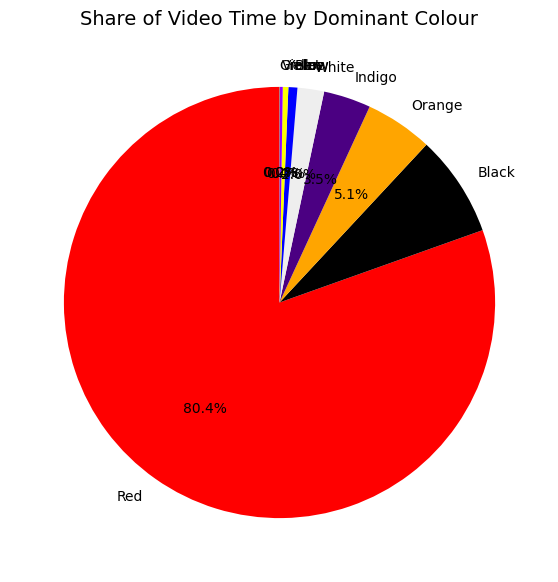

In [36]:
# Expand percentages to columns
percent_df = pd.DataFrame(df['pixel_percentages'].tolist())

# Dominant colour per frame
dominant_per_frame = percent_df.idxmax(axis=1)

# Share of time (frames) each colour is dominant
dominant_time_share = (dominant_per_frame.value_counts(normalize=True) * 100).sort_values(ascending=False)

print("Share of video time where each colour is dominant (%):")
print(dominant_time_share)

import matplotlib.pyplot as plt

# Use your color map
color_map = {
    'Violet': '#8F00FF',
    'Indigo': '#4B0082',
    'Blue':   '#0000FF',
    'Green':  '#00FF00',
    'Yellow': '#FFFF00',
    'Orange': '#FFA500',
    'Red':    '#FF0000',
    'White':  '#EEEEEE',  # Off-white for visibility
    'Black':  '#000000',
}

# Ensure colors align with labels
colors = [color_map[color] for color in dominant_time_share.index]

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(
    dominant_time_share,
    labels=dominant_time_share.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'color': 'black'}
)
plt.title("Share of Video Time by Dominant Colour", fontsize=14)
plt.show()



In [23]:
# If you have fps from earlier:
# fps = cap.get(cv2.CAP_PROP_FPS)

# Add time in seconds to df
df_sec = df.copy()
df_sec['t_sec'] = (df_sec.index / fps).astype(float)

# Floor to whole seconds and average within each second
percent_per_sec = (pd.DataFrame(df_sec['pixel_percentages'].tolist())
                   .assign(t_sec=df_sec['t_sec'].astype(int))
                   .groupby('t_sec', as_index=True)
                   .mean())

print("Per-second average colour % (first few rows):")
print(percent_per_sec.head())


Per-second average colour % (first few rows):
         Violet    Indigo      Blue     Green     Yellow     Orange  \
t_sec                                                                 
0      0.075833  6.969583  0.010833  0.001250   3.910000  27.468750   
1      0.070417  0.000000  0.000000  0.000000   4.296667  46.560000   
2      0.017083  0.000000  0.000000  0.010000  13.649583  55.850833   
3      0.000000  0.000000  0.000000  0.000000   7.169583  60.498750   
4      0.000000  0.000417  0.478750  0.007917   1.417083  58.290000   

             Red      White      Black  
t_sec                                   
0      14.932500  18.445000   2.502917  
1      33.472917   1.332917   3.114167  
2      18.516250   0.363750   9.102917  
3      18.212083   0.353333  11.130833  
4      20.806667   0.741250  14.480000  


In [24]:
dominant_per_sec = percent_per_sec.idxmax(axis=1)
dominant_time_share_per_sec = (dominant_per_sec.value_counts(normalize=True) * 100).sort_values(ascending=False)

print("Share of seconds where each colour is dominant (%):")
print(dominant_time_share_per_sec)


Share of seconds where each colour is dominant (%):
Red       82.013836
Black      7.583910
Orange     4.842429
Indigo     3.279529
White      1.101717
Blue       0.666154
Yellow     0.358698
Violet     0.153728
Name: proportion, dtype: float64


In [25]:
# Run-length encode dominant_per_sec to get contiguous segments
segments = []
curr_col = None
start = None

for t, col in dominant_per_sec.items():
    if curr_col is None:
        curr_col, start = col, t
    elif col != curr_col:
        segments.append({"colour": curr_col, "start_sec": start, "end_sec": t-1, "duration_sec": (t-1) - start + 1})
        curr_col, start = col, t

# close last
if curr_col is not None:
    last_t = dominant_per_sec.index.max()
    segments.append({"colour": curr_col, "start_sec": start, "end_sec": last_t, "duration_sec": last_t - start + 1})

segments_df = pd.DataFrame(segments).sort_values(['start_sec']).reset_index(drop=True)

print("Dominant-colour segments (per second):")
print(segments_df.head(20))  # show first 20


Dominant-colour segments (per second):
    colour  start_sec  end_sec  duration_sec
0   Orange          0        6             7
1      Red          7        9             3
2   Orange         10       11             2
3    White         12       12             1
4    Black         13       17             5
5     Blue         18       21             4
6   Indigo         22       22             1
7     Blue         23       24             2
8    Black         25       27             3
9    White         28       28             1
10   Black         29       29             1
11    Blue         30       33             4
12     Red         34       37             4
13  Indigo         38       39             2
14     Red         40       42             3
15   White         43       43             1
16  Indigo         44       45             2
17    Blue         46       46             1
18     Red         47       47             1
19  Indigo         48       55             8


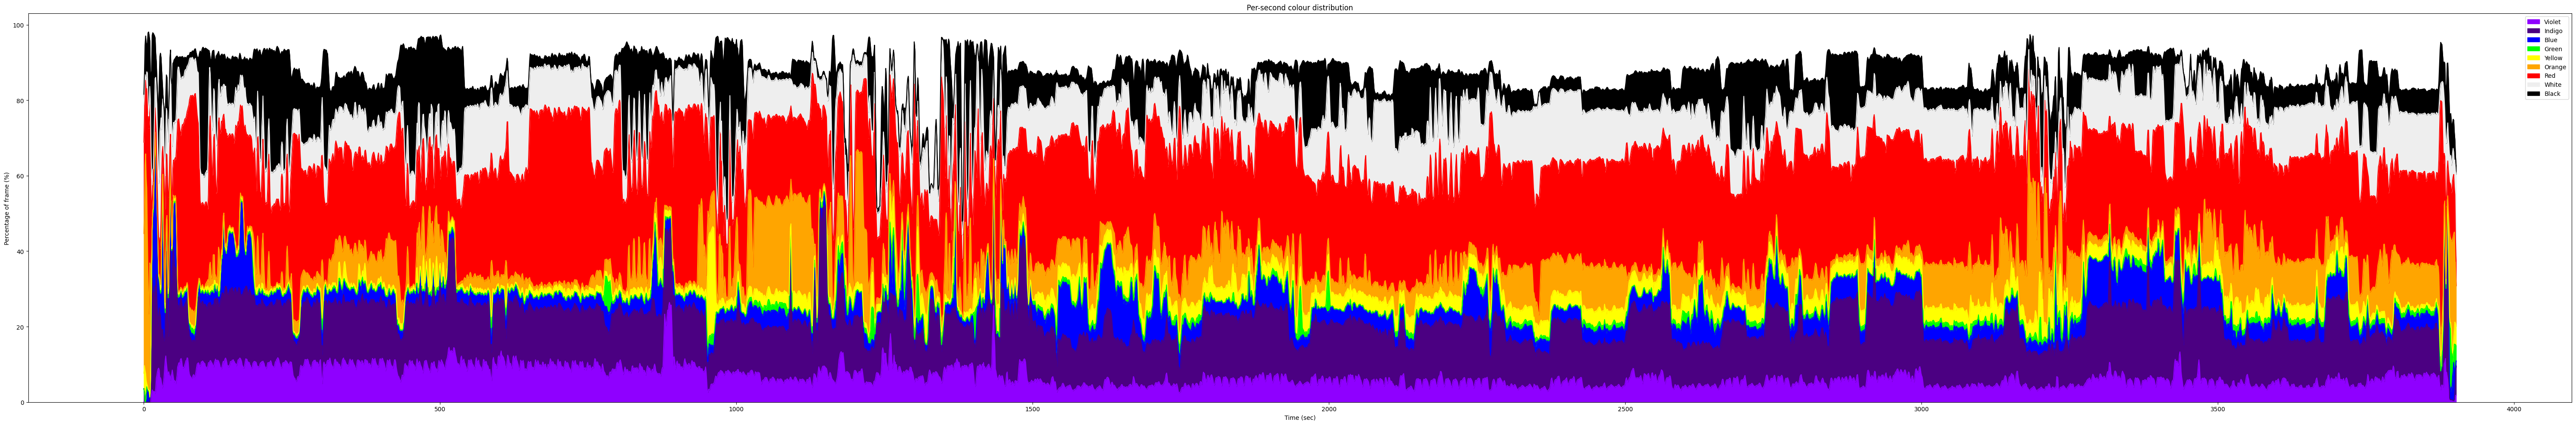

In [33]:
import matplotlib.pyplot as plt

# Suppose percent_per_sec columns are your color names
# Make sure you have a dictionary mapping each color name to its hex value
color_map = {
    'Violet': '#8F00FF',
    'Indigo': '#4B0082',
    'Blue':   '#0000FF',
    'Green':  '#00FF00',
    'Yellow': '#FFFF00',
    'Orange': '#FFA500',
    'Red':    '#FF0000',
    'White':  '#EEEEEE',  # Off-white for visibility
    'Black':  '#000000',
}

# Smooth the data
smooth = percent_per_sec.rolling(window=3, min_periods=1, center=True).mean()

# Plot with custom colors
ax = smooth.plot(
    kind="area",
    figsize=(60,10),
    color=[color_map[c] for c in smooth.columns]  # assign proper colors
)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Percentage of frame (%)")
ax.set_title("Per-second colour distribution")
plt.tight_layout()
plt.show()
